# Lab 1: Planar transformations and image rectification

The two main goals of this first lab are the following:

1) Get more familiar with the hierarchy of 2D transformations. <br>

2) Image rectification: Removal of the projective distortion of an image of a planar object.

This notebook combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

## **1. Image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to an image.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so that it contains the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [1]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates
from numpy import linalg as LA
from math import ceil
from utils import line_draw, plot_img, get_beg_end

def apply_H(I, H):
    h, w = I.shape[:2]

    #Get the 4 corners of the input image in homogeneous coordinates
    corners = np.array([
        [0,     0,     1],
        [w - 1, 0,     1],
        [w - 1, h - 1, 1],
        [0,     h - 1, 1]
    ]).T

    warped = H @ corners
    warped /= warped[2]

    xs = warped[0]
    ys = warped[1]

    xmin, xmax = int(np.floor(xs.min())), int(np.ceil(xs.max()))
    ymin, ymax = int(np.floor(ys.min())), int(np.ceil(ys.max()))

    out_w = xmax - xmin + 1
    out_h = ymax - ymin + 1
 
    #Build a grid containing all pixel coordinates of the output image
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax + 1),
        np.arange(ymin, ymax + 1)
    )

    pts_out = np.vstack([
        xx.ravel(),
        yy.ravel(),
        np.ones(xx.size)
    ])

    #Get inverse warp of all pixels
    H_inv = LA.inv(H)
    src = H_inv @ pts_out
    src /= src[2]

    x_src = src[0].reshape(out_h, out_w)
    y_src = src[1].reshape(out_h, out_w)

    #Interpolate using map_coordinates
    coords = [y_src.ravel(), x_src.ravel()] 

    if I.ndim == 2:
        #grayscale
        out = map_coordinates(
            I,
            coords,
            order=1,       # bilinear
            mode='constant',
            cval=0
        ).reshape(out_h, out_w)
    else:
        #3channel
        channels = []
        for c in range(I.shape[2]):
            ch = map_coordinates(
                I[:, :, c],
                coords,
                order=1,
                mode='constant',
                cval=0
            ).reshape(out_h, out_w)
            channels.append(ch)
        out = np.stack(channels, axis=2)

    return out


### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H that produces a similarity transformation. </span>

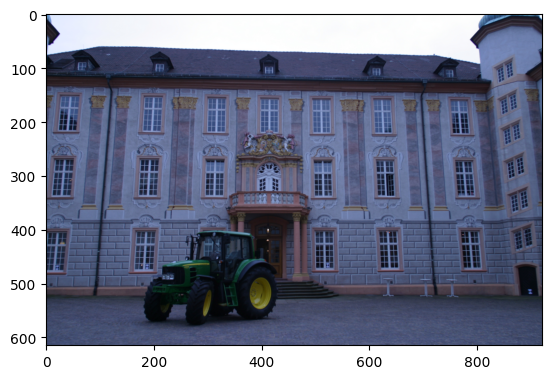

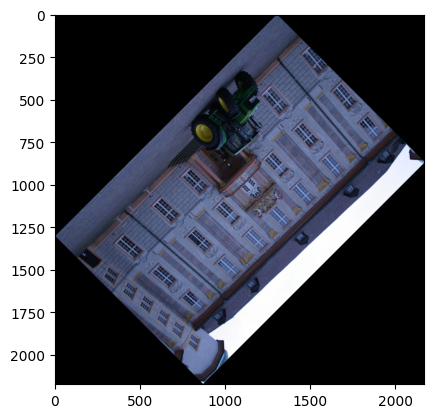

In [2]:
from math import pi, cos, sin

s = 2
theta = 3*pi/4
t = [1,2]

H = np.array([
    [s * cos(theta), -s * sin(theta), t[0]],
    [s * sin(theta),  s * cos(theta), t[1]],
    [0,               0,              1    ]
], dtype=float)

img_path = "./Data/0005_s.png"
I = Image.open(img_path)
I_sim = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_sim)

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H that produces an affine transformation.  </span>

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - Verify that the proper sequence of the four previous
transformations, applied over the image `I` **one by one**, produces the same transformed image as before.  </span>

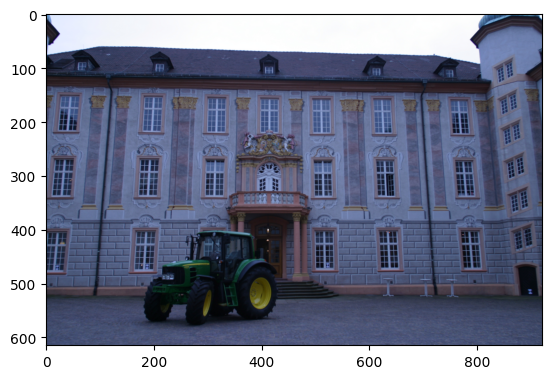

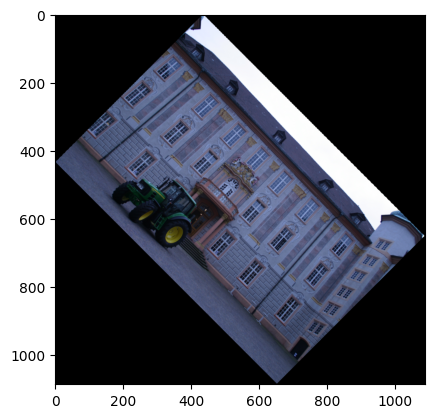

In [3]:
#Exmaple of H that produces an affine transformation:

theta = pi/4
t = [10,30]
A = np.array([[cos(theta), -sin(theta)], 
              [sin(theta), cos(theta)]], dtype=float)

H = np.array([[A[0,0],A[0,1],t[0]],
              [A[1,0],A[1,1],t[1]],
              [0,0,1]], dtype=float)

I_aff = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_aff)

In [4]:
#Decomposition into 4 matrices + H reconstruction verification

U, s_values, V_t = np.linalg.svd(A)
D = np.diag(s_values)

Rotation_1 = np.array([
    [U[0,0], U[0,1], 0],
    [U[1,0], U[1,1], 0],
    [0,0,1]
], dtype=float)

Scaling = np.array([
    [D[0,0], 0, 0],
    [0, D[1,1], 0],
    [0,0,1]
], dtype=float)

Rotation_2 = np.array([
    [V_t[0,0], V_t[0,1], 0],
    [V_t[1,0], V_t[1,1], 0],
    [0,0,1]
], dtype=float)

Translation = np.array([
    [1, 0, t[0]],
    [0, 1, t[1]],
    [0,0,1]
], dtype=float)

H_decomp = Translation @ Rotation_1 @ Scaling @ Rotation_2

print("H successfully reconstructed: ", np.allclose(H, H_decomp))

H successfully reconstructed:  True


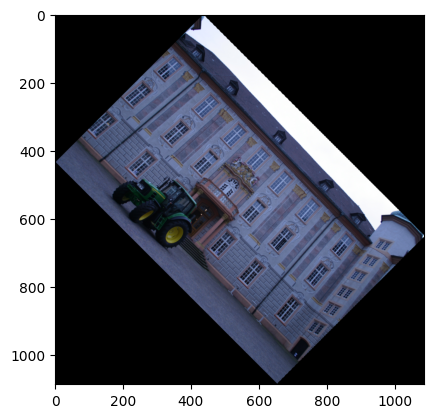

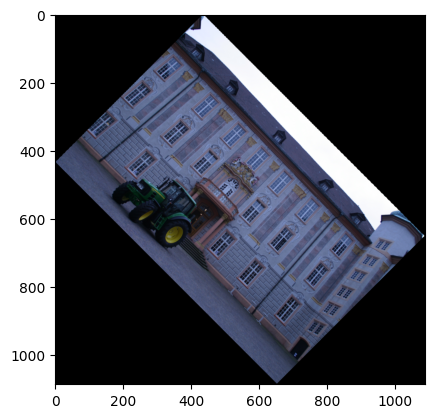

In [5]:
#Checking sequential application matches the full affine transform

I1 = apply_H(np.array(I), Rotation_2)
I2 = apply_H(np.array(I1), Scaling)
I3 = apply_H(np.array(I2), Rotation_1)
I_aff_decomp = apply_H(np.array(I3), Translation)

plot_img(I_aff_decomp)
plot_img(I_aff)


### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H that produces a projective transformation.  </span>

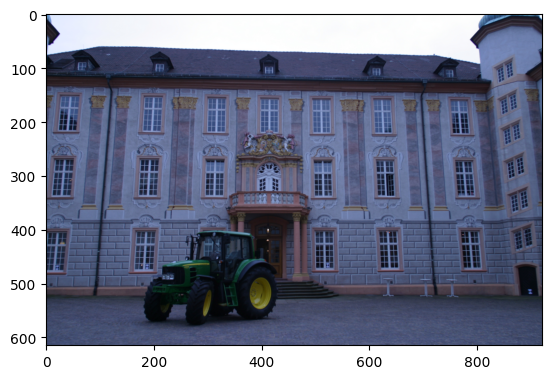

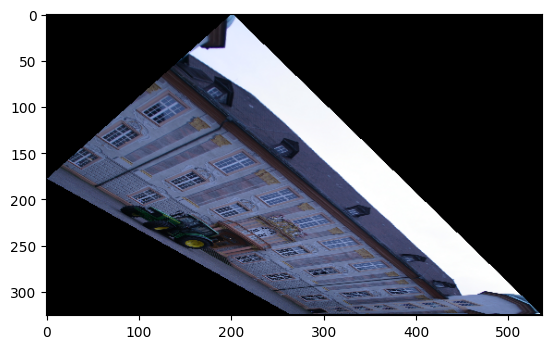

In [6]:
theta = pi/4
t = [10,30]
A = np.array([[cos(theta), -sin(theta)], 
              [sin(theta), cos(theta)]], dtype=float)
v_t = [0.001, 0.002]

H = np.array([[A[0,0],A[0,1],t[0]],
              [A[1,0],A[1,1],t[1]],
              [v_t[0],v_t[1],1]], dtype=float)

I_proj = apply_H(np.array(I), H)

plot_img(I)
plot_img(I_proj)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

### **2.1 Vanishing points estimated semi-automatically**

First, we will perform affine rectification by computing the vanishing points in a semi-automatic way. Line segments in the image will be detected automatically and then pairs of segments corresponding to imaged parallel lines will be manually selected. The segments are detected by the Line Segment Detector algorithm (paper [1], demo and code available in [2]). The result of this algorithm in the images of interest is already provided. The initial and final points of each detected segment are provided in a text file. The code below shows how to read the corresponding points for a certain segment given its index.  

[1] R. Grompone von Gioi, J. Jakubowicz, J.-M. Morel, G. Randall. LSD: a Line Segment Detector. , Image Processing On Line, 2, , pp. 35–55, 2012.

[2] http://www.ipol.im/pub/art/2012/gjmr-lsd/

In [7]:
# load images and lines
img_path = "./Data/0000_s.png"
I = Image.open(img_path)

lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 423 # line index (starting from 0)
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 239
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 564
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

<span style='color:Green'> - Compute the lines l1, l2, l3, l4, that pass through the different pairs of points.  </span>

In [8]:
# complete ...

l1, l2, l3, l4 = np.cross(p1, p2), np.cross(p3, p4), np.cross(p5, p6), np.cross(p7, p8)

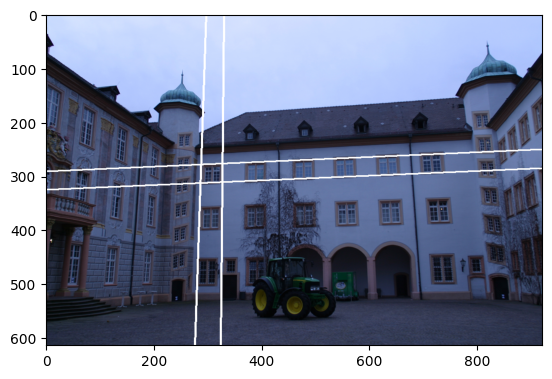

In [9]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)
point_color = (0, 0, 255)

line_draw(l1, canv, I.size)
line_draw(l2, canv, I.size)
line_draw(l3, canv, I.size)
line_draw(l4, canv, I.size)

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
I = Image.open(img_path)

<span style='color:Green'> - Compute the homography that affinely rectifies the image. </span>

<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>
      
<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>
      
<span style='color:Green'> - Verify, experimentally, that the cross-ratio is preserved after the image rectification (you may choose the endpoints of some detected line segments). </span>

H.T * l = [1.93498436e-04 1.48038626e-03 1.00000000e+00] = [0, 0, 1]


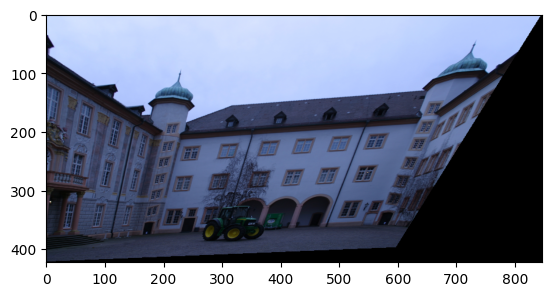

In [10]:
#Here we compute the homography that affinely rectifies the image
p_vanishing1 = np.cross(l1, l2)
p_vanishing2 = np.cross(l3, l4)

l = np.cross(p_vanishing1, p_vanishing2)

# Normalize or otherwise the homography explodes
l = l / l[2]

H = np.array([[1, 0, 0],
              [0, 1, 0],
              [l[0], l[1], l[2]]], dtype=float)

# Homography that affinely rectifies the image

print(f"H.T * l = {H.T @ l} = [0, 0, 1]")

I_proj = apply_H(np.array(I), H)

plot_img(I_proj)

In [11]:
def transform_points(points, H):
    transformed_points = [0] * len(points)
    for idx, p in enumerate(points):
        transformed_points[idx] = H @ p
        transformed_points[idx] = transformed_points[idx] / transformed_points[idx][2]
    return transformed_points

def get_lines(points):
    if len(points)%2 != 0:
        print("Number of points not even")
        return
    lines = [0] * (len(points)//2)
    idx = 0
    for i in range(1, len(points), 2):
        lines[idx] = np.cross(points[i-1], points[i])
        idx += 1

    return lines

def draw_lines(points, I_draw, canv):
    if len(points)%2 != 0:
        print("Number of points not even")
        return
    for i in range(1, len(points), 2):
        line = np.cross(points[i-1], points[i])
        line_draw(line, canv, I_draw.size)

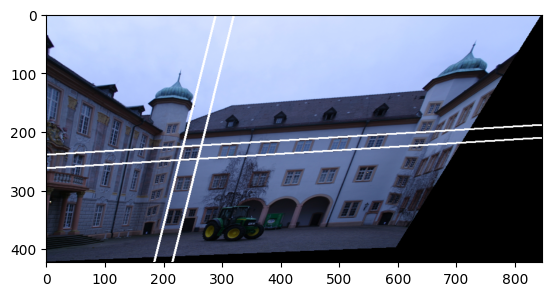

In [12]:
#Here we compute the rectified lines

points = [p1, p2, p3, p4, p5, p6, p7, p8]

rectified_points = transform_points(points, H)

I_draw = Image.fromarray(I_proj)

canv = ImageDraw.Draw(I_draw)
point_color = (0, 0, 255)

draw_lines(rectified_points, I_draw, canv)

plot_img(I_draw)

In [13]:
#Here we compute the angles between paralel lines before and after rectification to evaluate the results

pr1, pr2, pr3, pr4, pr5, pr6, pr7, pr8 = rectified_points

lr1, lr2, lr3, lr4 = get_lines(rectified_points)

C = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 0]], dtype=float)

cos_l1_l2 = l1.T @ C @ l2 / np.sqrt((l1.T@C@l1)*(l2.T@C@l2))
cos_lr1_lr2 = lr1.T @ C @ lr2 / np.sqrt((lr1.T@C@lr1)*(lr2.T@C@lr2))

angle_l1_l2 = np.arccos(cos_l1_l2)
angle_lr1_lr2 = np.arccos(cos_lr1_lr2)

cos_l3_l4 = l3.T @ C @ l4 / np.sqrt((l3.T@C@l3)*(l4.T@C@l4))
cos_lr3_lr4 = lr3.T @ C @ lr4 / np.sqrt((lr3.T@C@lr3)*(lr4.T@C@lr4))

angle_l3_l4 = np.arccos(cos_l3_l4)
angle_lr3_lr4 = np.arccos(cos_lr3_lr4)

print(f"Angle between l1 and l2: {angle_l1_l2/pi * 180}")
print(f"Angle between lr1 and lr2: {angle_lr1_lr2/pi * 180}")
print(f"Angle between l3 and l4: {angle_l3_l4/pi * 180}")
print(f"Angle between lr3 and lr4: {angle_lr3_lr4/pi * 180}")
print("Now angles have become 0 or 180, so they are now paralel")

Angle between l1 and l2: 0.09918160389298211
Angle between lr1 and lr2: 1.2074182697257333e-06
Angle between l3 and l4: 178.65646269578093
Angle between lr3 and lr4: 180.0
Now angles have become 0 or 180, so they are now paralel


In [14]:
#Here we verify that the cross-ratio is preserved

def project_onto_line(P, L1, L2):
    # vector along line
    v = np.array(L2) - np.array(L1)
    v = v / np.linalg.norm(v)
    # vector from L1 to P
    w = np.array(P) - np.array(L1)
    # scalar projection
    return np.dot(w, v)

#Let's first compute the cross ratio for the points p1, p2 and the begining and ending of the line that cross them

A, D = get_beg_end(l1, I.size)
B, C = p1[:2], p2[:2]

a, b, c, d = [project_onto_line(p, A, D) for p in [A, B, C, D]]
cross_ratio1 = ((c - a) * (d - b)) / ((b - a) * (d - c))

#Now let's compute it for the rectified points

A, D = get_beg_end(lr1, I.size)
B, C = pr1[:2], pr2[:2]

a, b, c, d = [project_onto_line(p, A, D) for p in [A, B, C, D]]
cross_ratio2 = ((c - a) * (d - b)) / ((b - a) * (d - c))

print(f"Original Cross ratio = {cross_ratio1}")
print(f"New Cross Ratio = {cross_ratio2}")
print("We have almost the same. Difference probably because of accumulation of numerical errors")

Original Cross ratio = 1.1935389038864959
New Cross Ratio = 1.1723092889281927
We have almost the same. Difference probably because of accumulation of numerical errors


### **2.2 Vanishing points estimated automatically** 

The vanishing points in an image can be estimated automatically. In this lab, we will use the orthogonal vanishing points estimated by the technique proposed in [3] (code available in [4]), which actually uses the line segments estimated with the LSD algorithm [1] used before.

In this section, we will work with the image 'friends.jpeg'. The estimated vanishing points obtained by [3] are provided in the file 'friends_vps.out' (see code below for more details).

[3] Xiaohu Lu, Jian Yao, Haoang Li, Yahui Liu. 2-Line Exhaustive Searching for Real-Time Vanishing Point Estimation in Manhattan World. IEEE/CVF Winter Conference on Applications of Computer Vision (WACV), 2017.

[4] https://github.com/rayryeng/XiaohuLuVPDetection

<span style='color:Green'> - Perform affine rectification of this image using the appropriate vanishing points automatically detected. **Justify your choice** of vanishing points. </span>

H.T * l = [-1.71538208e-03  5.90653402e-04  1.00000000e+00] = [0, 0, 1]


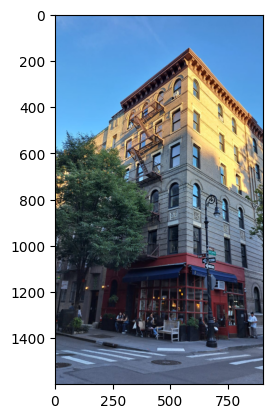

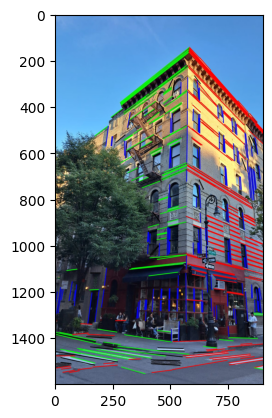

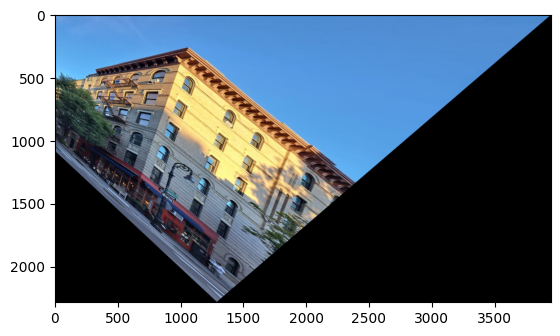

In [15]:
# Visualize image 'friends.jpeg'
I = Image.open("./Data/friends.jpeg")

plot_img(I)

# Visualize image 'friends_vps.jpeg' which shows the different line segments detected by LSD [1] and groups
# them in three different colors according to the different vanishing points they have been associated.
plot_img(Image.open("./Data/friends_vps.jpeg"))
# Load the three orthogonal vanishing points from image 'friends.jpeg' (estimated by [3,4])
vps = np.loadtxt('./Data/friends_vps.out', delimiter=',')
# 'vps' is a numpy array where each row is a vanishing point and each column is a coordinate.
# The first, second and third rows in 'vps' correspond to the vanishing points corresponding to,
# respectively, red, green, and blue directions.

"""

We will be using vanishing points 1 (red) and 3 (blue), however 2 (green) and 3 (blue) could be used too. 1 (red) and 2 (green)
cannot be used together, because they are in different planes. So the chosing of the points will determine which face of the
building we are rectifiying, in this case the right one.

"""

p_vanishing1 = [vps[0][0], vps[0][1], 1]
p_vanishing2 = [vps[2][0], vps[2][1], 1]
l = np.cross(p_vanishing1, p_vanishing2)
l = l / l[2]

H = np.array([[1, 0, 0],
              [0, 1, 0],
              [l[0], l[1], l[2]]], dtype=float)

# Homography that affinely rectifies the image

print(f"H.T * l = {H.T @ l} = [0, 0, 1]")

I_proj = apply_H(np.array(I), H)

plot_img(I_proj)

## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

We will work with image 0000.

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.
      
<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>
      


In [16]:
"""

Computing S is an undetermined problem (it has infinite solutions),
so we will be fixing s1 = 1 and then proceed to compute all the other values

"""

def compute_S(pair1, pair2):

    (l1, m1), (l2, m2) = pair1, pair2


    #These are the constraints that deppend on S12 and S22, the ones
    #for S11 will be passed to b, since we already fixed S11 = 1
    A = np.array([
        [l1[0]*m1[1] + l1[1]*m1[0], l1[1]*m1[1]],
        [l2[0]*m2[1] + l2[1]*m2[0], l2[1]*m2[1]]
    ])

    b = np.array([
        -l1[0]*m1[0],
        -l2[0]*m2[0]
    ])

    s12, s22 = np.linalg.solve(A, b)

    S = np.array([[1, s12],
                  [s12, s22]], dtype=float)
    
    return S


In [17]:
def apply_H_with_translation(I, H):
    h, w = I.shape[:2]

    # Corners of the original image
    corners = np.array([[0,0,1],[w,0,1],[w,h,1],[0,h,1]]).T
    corners_trans = H @ corners
    corners_trans /= corners_trans[2,:]

    # Compute translation to keep all pixels visible
    min_x = np.min(corners_trans[0,:])
    min_y = np.min(corners_trans[1,:])
    T = np.eye(3)
    T[0,2] = -min_x
    T[1,2] = -min_y

    # Compose final homography
    H_full = T @ H

    # Warp image using H_full (depends on your apply_H implementation)
    I_warped = apply_H(I, H)

    return I_warped, H_full

H.T * l = [-7.60941825e-04  1.03551983e-03  1.00000000e+00] = [0, 0, 1]
[[ 1.         -0.28952911]
 [-0.28952911  0.94318182]]
[0.68067137 1.26251045]


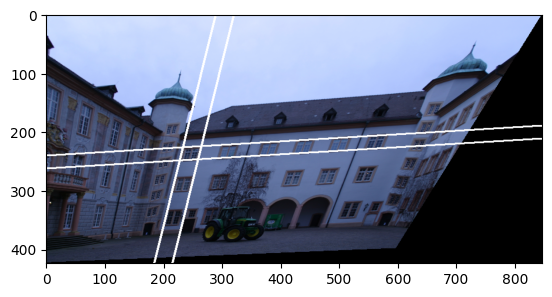

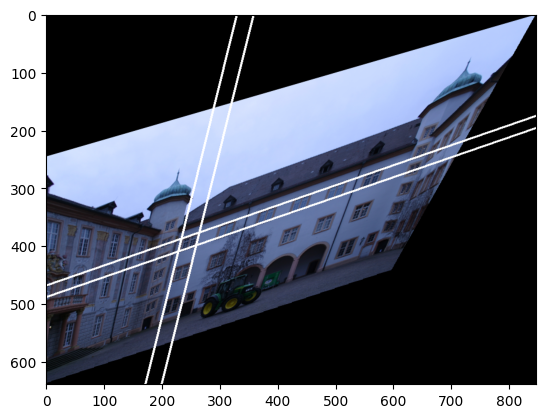

In [30]:
I = Image.open("./Data/0000_s.png")
p_vanishing1 = np.cross(l1, l2)
p_vanishing2 = np.cross(l3, l4)

l = np.cross(p_vanishing1, p_vanishing2)

# Normalize or otherwise the homography explodes
l = l / l[2]

H_aff = np.array([[1, 0, 0],
              [0, 1, 1],
              [l[0], l[1], l[2]]], dtype=float)

# Homography that affinely rectifies the image

print(f"H.T * l = {H.T @ l} = [0, 0, 1]")

I_aff_corr = apply_H(np.array(I), H_aff)

rectified_points = transform_points(points, H_aff)

I_draw = Image.fromarray(I_aff_corr)
canv = ImageDraw.Draw(I_draw)

draw_lines(rectified_points, I_draw, canv)

plot_img(I_draw)

#Now let's go for the metric rectification. For pairs, lines 1 and 4, and lines 2 and 3 are orthogonal

orth_pair1 = (lr1, lr4)
orth_pair2 = (lr2, lr3)


S = compute_S(orth_pair1, orth_pair2)

print(S)

#Lo de como sacar K me lo ha dicho Claude, así que pues bueno, yo no aseguro nada
vals, _ = np.linalg.eigh(S)
print(vals)  # should all be >0, fuck
K = np.linalg.cholesky(S)
H_metr = np.eye(3)
H_metr[:2, :2] = K

#Let's see what do we get with this thingy
I_met_corr = apply_H(I_aff_corr, H_metr)

I_met_corr, H_full = apply_H_with_translation(I_aff_corr, H_metr)

metric_rect_points = transform_points(rectified_points, H_full)

I_draw = Image.fromarray(I_met_corr)
canv = ImageDraw.Draw(I_draw)

draw_lines(metric_rect_points, I_draw, canv)

plot_img(I_draw)

In [26]:
#Here we compute the angles between paralel lines before and after rectification to evaluate the results

pr1, pr2, pr3, pr4, pr5, pr6, pr7, pr8 = metric_rect_points

lmr1, lmr2, lmr3, lmr4 = get_lines(metric_rect_points)

C = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 0]], dtype=float)

cos_l1_l4 = l1.T @ C @ l4 / np.sqrt((l1.T@C@l1)*(l4.T@C@l4))
cos_lmr1_lmr4 = lmr1.T @ C @ lmr4 / np.sqrt((lmr1.T@C@lmr1)*(lmr4.T@C@lmr4))

angle_l1_l4 = np.arccos(cos_l1_l4)
angle_lmr1_lmr4 = np.arccos(cos_lmr1_lmr4)

cos_l2_l3 = l2.T @ C @ l3 / np.sqrt((l2.T@C@l2)*(l3.T@C@l3))
cos_lmr2_lmr3 = lmr2.T @ C @ lmr3 / np.sqrt((lmr2.T@C@lmr2)*(lmr3.T@C@lmr3))

angle_l2_l3 = np.arccos(cos_l2_l3)
angle_lmr2_lr3 = np.arccos(cos_lmr2_lmr3)

print(f"Angle between l1 and l4: {angle_l1_l4/pi * 180}")
print(f"Angle between lmr1 and lmr4: {angle_lmr1_lmr4/pi * 180}")
print(f"Angle between l2 and l3: {angle_l2_l3/pi * 180}")
print(f"Angle between lmr2 and lmr3: {angle_lmr2_lr3/pi * 180}")
print("Now angles have become 90 or 270, so they are now paralel")

Angle between l1 and l4: 93.20244323238278
Angle between lmr1 and lmr4: 122.99244018257049
Angle between l2 and l3: 85.55320106729347
Angle between lmr2 and lmr3: 57.00755981742951
Now angles have become 90 or 270, so they are now paralel


## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      
      

## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification of the white facade of image 0000 in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.